# **eZnalec - Price predicting & analytic model for apartments**

In [18]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data preparation (MICE)

Load the data

In [10]:
df = pd.read_csv('merged_apt_data.csv')
df.head()


,price,1+1,1+kk,2+1,2+kk,3+1,3+kk,4+1,4+kk,5+1,...,kindergarden,small_store,big_store,pub,restaurant,post_office,atm,nature_place,pharmacy,sports
0,6148000,0,0,0,1,0,0,0,0,0,...,577,319,966.0,1110,62,1003,693,2609.0,644,62
1,9490000,0,0,0,1,0,0,0,0,0,...,294,431,1809.0,301,197,364,523,NaN,609,387
2,19373005,0,0,0,0,0,1,0,0,0,...,319,707,707.0,1634,374,799,483,1883.0,776,676
3,7000000,0,0,0,1,0,0,0,0,0,...,196,76,1635.0,774,97,961,382,4511.0,542,81
4,26278859,0,0,0,0,0,1,0,0,0,...,468,732,1466.0,1017,619,1077,820,NaN,962,592


Inspect the missing data

In [11]:
missing_values = df.isnull().sum()
missing_values

#here we can see how many energy levels are missing in our dataset for example
missing_energy_level = df['energy_level'].isnull().sum()
missing_energy_level

np.int64(392)

Applying MICE

In [12]:
imputer = IterativeImputer()
df_imputed = imputer.fit_transform(df)
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)
#we can see that the energy levels which are not .00 are now imputed
df_imputed['energy_level'].head(30)

0     7.000000
1     1.000000
2     2.000000
3     4.000000
4     2.000000
5     3.439727
6     2.000000
7     2.000000
8     3.000000
9     2.000000
10    2.000000
11    7.000000
12    3.568650
13    2.000000
14    2.000000
15    4.000000
16    3.543069
17    2.650231
18    2.962034
19    4.923415
20    2.000000
21    2.000000
22    3.000000
23    7.000000
24    3.000000
25    7.000000
26    3.000000
27    3.000000
28    1.000000
29    4.000000
Name: energy_level, dtype: float64

Evaluation of imputation

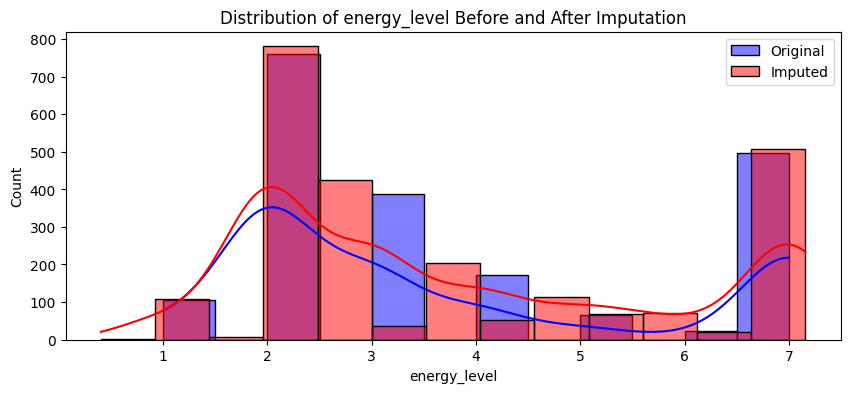

In [13]:
# Visualize the distribution of a few selected columns before and after imputation
import matplotlib.pyplot as plt
import seaborn as sns

# Select column to visualize
column = 'energy_level'  

plt.figure(figsize=(10, 4))

# Original data distribution
sns.histplot(df[column].dropna(), color='blue', label='Original', kde=True)

# Imputed data distribution
# This exapmle is for the energy level column, feel free to change the column name to visualize other columns
sns.histplot(df_imputed[column], color='red', label='Imputed', kde=True)

plt.title(f'Distribution of {column} Before and After Imputation')
plt.legend()



plt.show()

Data separation

In [14]:
y = df_imputed['price']
X = df_imputed.drop(columns=['price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the model

Linear regression with elastic net normalization and cross-validation methodology for data

In [15]:
#first test on ols model, the most basic
ols = LinearRegression()
ols.fit(X_train, y_train)

print("r^2 on train data is {}".format(ols.score(X_train, y_train)))
print("r^2 on test data is {}".format(ols.score(X_test, y_test)))

r^2 on train data is 0.9384620901171774
r^2 on test data is 0.908093956107316


Here it can be seen that on the test data, model can predict price on 90% accuracy, it is pretty good but it can be better.
Next will be ElasticNet normalization (L1+L2).

In [23]:
elastic_net = ElasticNet()
parameters = {
    'alpha': np.linspace(0.01, 10.0, 20),
    'l1_ratio': np.linspace(0.01, 0.9, 20)
}

grid_search = GridSearchCV(estimator=elastic_net, param_grid=parameters, cv=10, scoring='r2')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

best_model = grid_search.best_estimator_


y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("r2 on test data: ", r2)

Best parameters found:  {'alpha': np.float64(0.01), 'l1_ratio': np.float64(0.8063157894736842)}
r2 on test data:  0.9106576067940632


The best alpha (strength of the reqularization) is 0.01 and l1_ratio (lasso) is 0.80. Which means that we are using 80% Lasso and 20% Ridge. Plus we did 10 folds on cross validation for the data.

# Analysis

Feature importance

Text(0.5, 1.0, 'Top 20 Features in Elastic Net Model (absolute value of coefficients)')

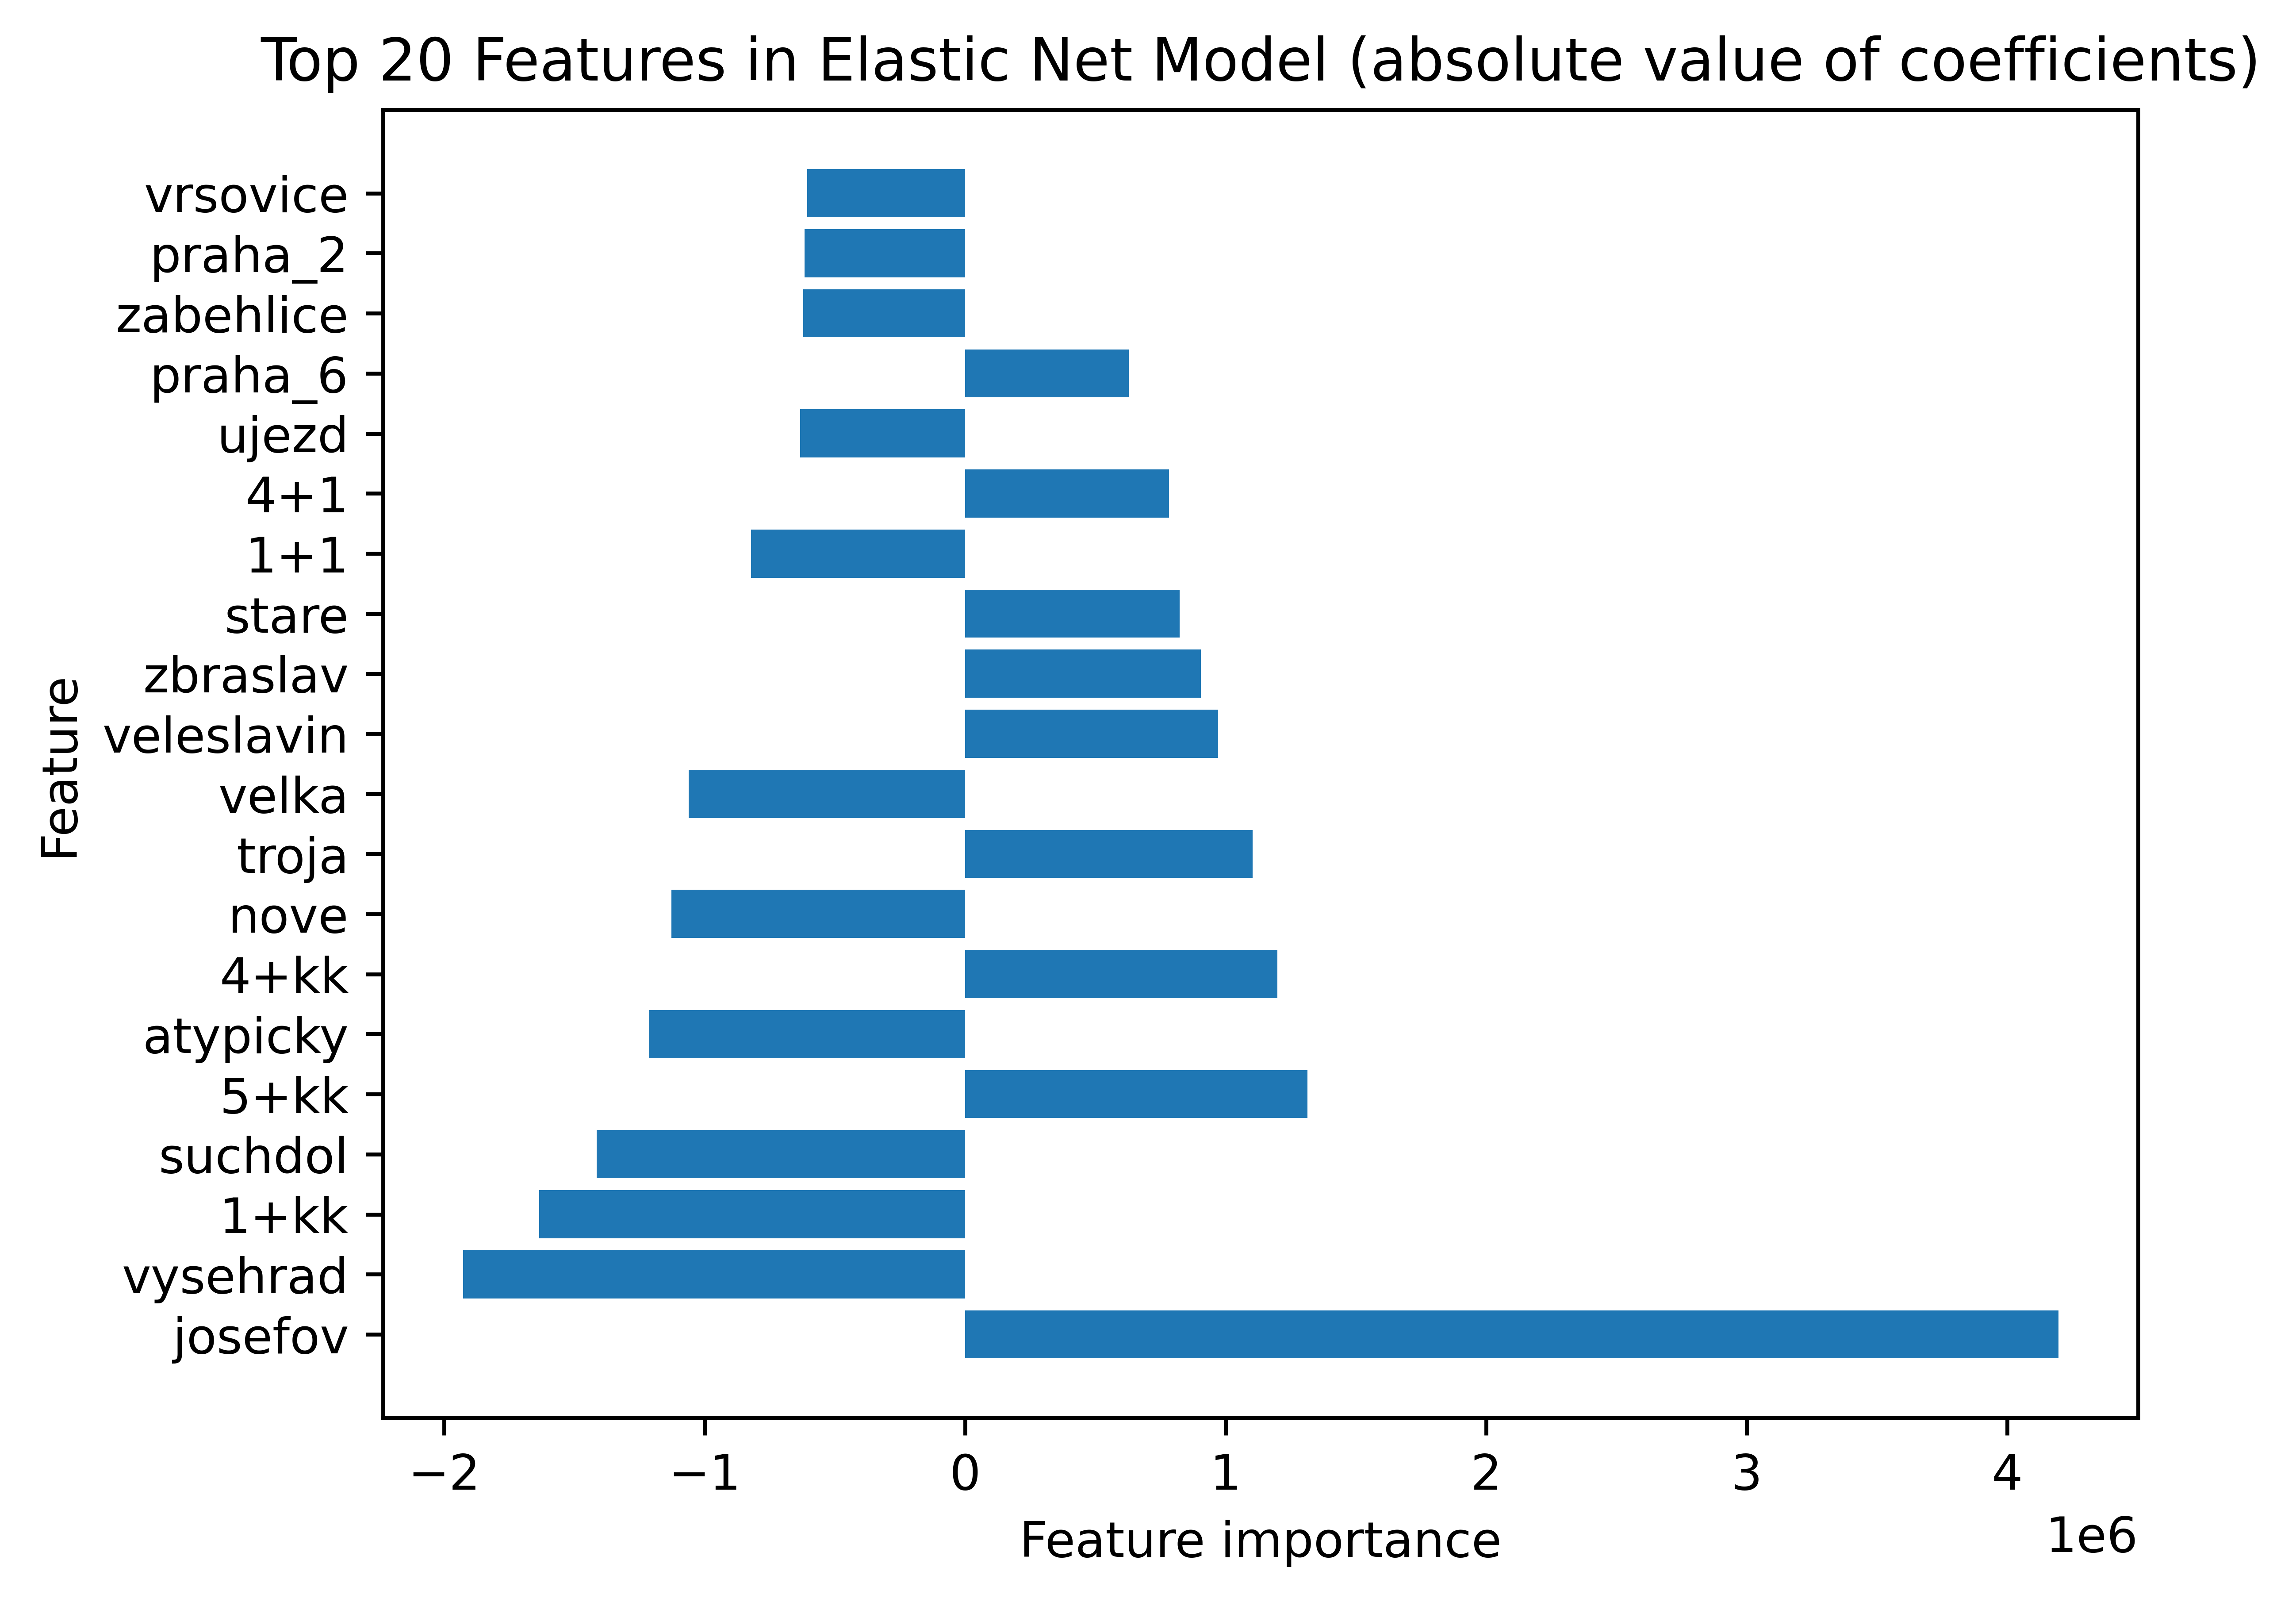

In [28]:
coef_abs = np.abs(best_model.coef_)
top_20_feature = np.argsort(coef_abs)[-20:][::-1]
plt.figure(dpi=800)
plt.barh(range(20), best_model.coef_[top_20_feature], align='center')
plt.yticks(range(20), X.columns[top_20_feature])
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.title("Top 20 Features in Elastic Net Model (absolute value of coefficients)")

- Here we can see that "thanks" for one-hot-encoding method for locations in prague most of the top 20 features are the specific location.
- Our model evaluated that Josefov (historical centre of Prague) is very imporant in price prediciting and that the apartment prices in Vysehrad (good location near centre) are not very bound to the location (this feature is not important in final price), which is very interesting.
- Otherwise, we can see that the apartment's rooms dispositions are also very important, however, just the larger ones.
